# Exercise 2

In [2]:
from pset.algorithms import SGA

def run_simulation():
    """Run SGA simulation of the one-max problem."""
    sim = SGA()
    sim.run()
    mean, std, best = sim.fitness_over_time[:]
    assert(len(mean) == len(best))
    for l in [mean, std, best]:
        while len(l) < 100:
            l.append(l[-1])
    return mean, std, best

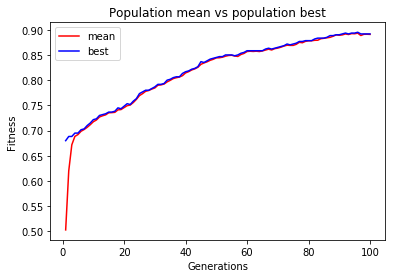

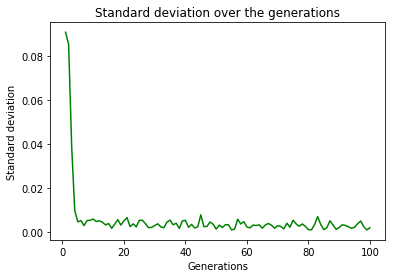

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def update_list(current, new):
    return map(lambda c, n: c + n, current, new)

mean, std, best = [0]*100, [0]*100, [0]*100
for i in range(20):
    m, s, b = run_simulation()
    mean = update_list(mean, m)
    std = update_list(std, s)
    best = update_list(best, b)
    
X = np.array(range(1, 101))
mean = [x/20 for x in mean]
std = [x/20 for x in std]
best = [x/20 for x in best]

plt.figure('Mean vs best')
plt.title("Population mean vs population best")
mean_plt, = plt.plot(X, mean, 'r', label='mean')
best_plt, = plt.plot(X, best, 'b', label='best')
plt.legend(handles=[mean_plt, best_plt])
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.savefig('./assets/ex2_mean.png')
plt.show()

plt.figure('STD')
plt.title("Standard deviation over the generations")
plt.plot(X, std, 'g')
plt.xlabel('Generations')
plt.ylabel('Standard deviation')
plt.savefig('./assets/ex2_std.png')
plt.show()

# Exercise 3

In [5]:
from pset.algorithms import SGA

class CustomSGA(SGA):
    """Custom SGA.
    
    Overrides SGA's run method to yield population
    upon each generation.
    """
    
    def run(self):
        population = self.initialize()
        pop_mean = self.population_fitness(population, update=True)[0]
        yield self.generations, population, pop_mean

        while self.generations < self.MAX_TRIALS and (1 - pop_mean) > self.PRECISION:
            parents = self.select_parents(population)
            offspring = self.recombine(parents)
            self.mutate(offspring)

            population = self.select_new_population(population + offspring, n=self.POP_SIZE)

            pop_mean = self.population_fitness(population, update=True)[0]
            self.generations += 1
            yield self.generations, population, pop_mean

        self.last_pop = population

In [4]:
import numpy as np
import schematax
import time

sim = CustomSGA()

# Used to sove population data in file for later schema proccessing
for results in sim.run():
    generation, population, _ = results[0], results[1], results[2]
    file = open('./data/new_individuals/' + str(generation) + '.txt', 'w')
    file.write('\n'.join([p.chromosome for p in population]))
    file.close()

### Load computed schemas

Schemas were computed outside this notebook using the population files generated by
the previous code section, refer to `pset.create_schema_from_populatoin` script for
more details about schema generaion using *SCHEMATAX*.

**Note**: *SCHEMATAX* generate duplicates when computing schemas from population.

**Note 2**: Histogram was skipped since all building blocks appeared either 1 o
2 times during evolution. Top 10/15 is listed at the end.

**Note 3**: Since the first population had a lot of variaety on its chromosomes
a total of **5695** unique schemas were found (look at `data/schemas/0.schema`) but that
number drops dramatically on the first generation with only **78** unique schemas
and then to a number betwee $[1, 3]$ unique schemas for the remaining generations

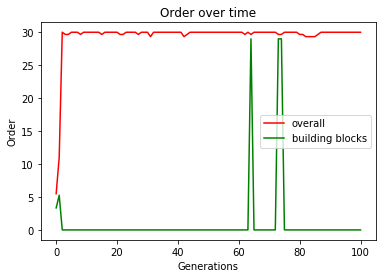

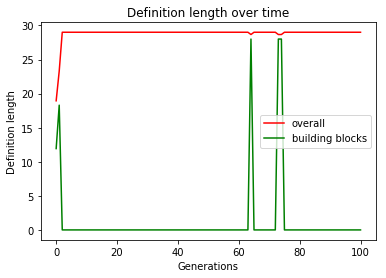

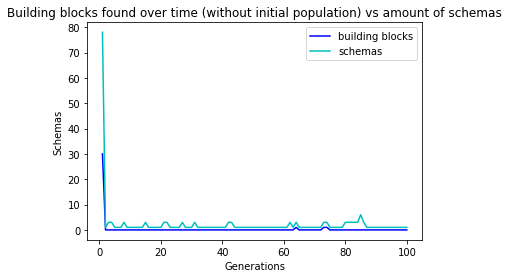

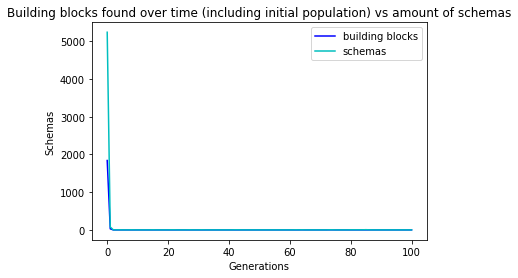

------------------------------------------------------------
Top 10 building blocks (without initial popuation)

Frequency 	 Schema 				 Appeared in generations
2 		 11100111111011111011111111111* 	 [73, 74]
1 		 *********1**************1***** 	 [1]
1 		 **************1***0**1**1***** 	 [1]
1 		 ************************1***** 	 [1]
1 		 ***********0************1***** 	 [1]
1 		 *******0**1*************1***** 	 [1]
1 		 ********01**************1***** 	 [1]
1 		 ********0***************1***** 	 [1]
1 		 ********01**************10**** 	 [1]
1 		 ********0**0************1***** 	 [1]
------------------------------------------------------------
Top 15 building blocks (including initial popuation)

Frequency 	 Schema 				 Appeared in generations
2 		 *********1**************1***** 	 [0, 1]
2 		 **************1***0**1**1***** 	 [0, 1]
2 		 ************************1***** 	 [0, 1]
2 		 ***********0************1***** 	 [0, 1]
2 		 *******0**1*************1***** 	 [0, 1]
2 		 ********01***********

In [70]:
import numpy as np
import schematax
import toolz


X = np.array(range(101))

overall_results = {
    'order': [None] * 101,
    'definition_length': [None] * 101,
    'building_blocks_over_time': [None] * 101,
    'schemas_count': [None] * 101
}
building_blocks = {
    'order': [None] * 101,
    'definition_length': [None] * 101,
    'schemas_freq': {},
    'schemas_freq_wo': {}
}

for i in range(101):
    # Load schemas from file
    schema_file = open('data/schemas/{}.schema'.format(i), 'r').readlines()
    schemas = []
    for l in schema_file[1:]:
        s = l.split(',')
        schemas.append((s[0], int(s[1]), int(s[2])))
        
    # Remove duplicates
    schemas = [x for x in toolz.unique(schemas, key=lambda x: str(x))]
    overall_results['schemas_count'][i] = len(schemas)

    # Retrieve generation stats
    order = [s[1] for s in schemas]
    definition_length = [s[2] for s in schemas]

    # Update generation stats
    order_m = np.mean(order)
    definition_length_m = np.mean(definition_length)
    overall_results['order'][i] = order_m
    overall_results['definition_length'][i] = definition_length_m
    
    # Retrieve building blocks
    bbs = []
    for s in schemas:
        if s[1] < order_m and s[2] < definition_length_m:
            bbs.append(s)
    overall_results['building_blocks_over_time'][i] = len(bbs) 

    # Update building blocks stats
    building_blocks['order'][i] = np.mean([x[1] for x in bbs]) if len(bbs) > 0 else 0
    building_blocks['definition_length'][i] = np.mean([x[2] for x in bbs]) if len(bbs) > 0 else 0

    # Update building blocks appearances
    for bb in bbs:
        bb_schema = building_blocks['schemas_freq'].setdefault(bb[0], {'freq': 0, 'appeared_in': []})
        bb_schema_wo = building_blocks['schemas_freq_wo'].setdefault(bb[0], {'freq': 0, 'appeared_in': []})
        bb_schema['freq'] += 1
        bb_schema['appeared_in'].append(i)
        if i > 0:
            bb_schema_wo['appeared_in'].append(i)
            bb_schema_wo['freq'] += 1

        
plt.figure('Schemas order')
plt.title('Order over time')
order_plt, = plt.plot(X, overall_results['order'], 'r', label='overall')
bb_order_plt, = plt.plot(X, building_blocks['order'], 'g', label='building blocks')
plt.xlabel('Generations')
plt.ylabel('Order')
plt.legend(handles=[order_plt, bb_order_plt])
plt.show()

plt.figure('Schemas definition length')
plt.title('Definition length over time')
order_plt, = plt.plot(X, overall_results['definition_length'], 'r', label='overall')
bb_order_plt, = plt.plot(X, building_blocks['definition_length'], 'g', label='building blocks')
plt.xlabel('Generations')
plt.ylabel('Definition length')
plt.legend(handles=[order_plt, bb_order_plt])
plt.show()

plt.figure('Building blocks found over time (without initial population)')
plt.title('Building blocks found over time (without initial population) vs amount of schemas')
bb_wo_plt, = plt.plot(X[1:], overall_results['building_blocks_over_time'][1:], 'b', label='building blocks')
ss_wo_plt, = plt.plot(X[1:], overall_results['schemas_count'][1:], 'c', label='schemas')
plt.xlabel('Generations')
plt.ylabel('Schemas')
plt.legend(handles=[bb_wo_plt, ss_wo_plt])
plt.show()

plt.figure('Building blocks found over time (including initial population)')
plt.title('Building blocks found over time (including initial population) vs amount of schemas')
bb_wo_plt, = plt.plot(X, overall_results['building_blocks_over_time'], 'b', label='building blocks')
ss_wo_plt, = plt.plot(X, overall_results['schemas_count'], 'c', label='schemas')
plt.xlabel('Generations')
plt.ylabel('Schemas')
plt.legend(handles=[bb_wo_plt, ss_wo_plt])
plt.show()

print('-' * 60)
print("Top 10 building blocks (without initial popuation)\n")
top_10 = sorted(building_blocks['schemas_freq_wo'].items(), key=lambda x: x[1]['freq'], reverse=True)[:10]
print('Frequency \t Schema \t\t\t\t Appeared in generations')
for t in top_10:
    print(t[1]['freq'], '\t\t', t[0], '\t', t[1]['appeared_in'])
    
print('-' * 60)
print("Top 15 building blocks (including initial popuation)\n")
top_10 = sorted(building_blocks['schemas_freq'].items(), key=lambda x: x[1]['freq'], reverse=True)[:15]
print('Frequency \t Schema \t\t\t\t Appeared in generations')
for t in top_10:
    print(t[1]['freq'], '\t\t', t[0], '\t', t[1]['appeared_in'])